# 데이터 로드

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
def load_dataset(csv_path, TRAIN_RATIO=0.8):
    
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 성별 원핫 인코딩
    df=pd.get_dummies(df,columns=['Sex'])
    
    # 학습 데이터 분리
    X = df.drop('Rings', axis=1)
    y = df['Rings']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    return X_train, X_test, y_train, y_test

csv_path = '../colabo/Data/Regression_data.csv'
X_train, X_test, y_train, y_test = load_dataset(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3341, 10) (836, 10) (3341,) (836,)


In [2]:
# 전복 전체 무게가 살 + 내장 + 껍질보다 적게 나가는 경우는 말이 안됨
body = X_train['Whole weight'] - (X_train['Shucked weight'] + X_train['Viscera weight'] + X_train['Shell weight'])
X_train['body'] = body

index = X_train[X_train['body'] < 0].index

body = X_test['Whole weight'] - (X_test['Shucked weight'] + X_test['Viscera weight'] + X_test['Shell weight'])
X_test['body'] = body

index2 = X_test[X_test['body'] < 0].index

print(index.shape, index2.shape)

(118,) (37,)


In [3]:
X_train.drop(index, axis=0, inplace=True)
X_test.drop(index2, axis=0, inplace=True)

In [4]:
# Lenth가 Diameter보다 크다.
# --> Length는 장축의 길이, Diameter는 단축의 지름으로 판단됨
# 타원(전복 껍데기)의 둘레 및 넓이 구해보기
# Length가 Diameter보다 큰게 딱 1개 있음 --> 그럴 수도 있으니 삭제는 안함
index3 = X_train[X_train['Diameter'] > X_train['Length']].index
index4 = X_test[X_test['Diameter'] > X_test['Length']].index
print(index3.shape, index4.shape)

(1,) (0,)


In [5]:
import numpy as np

# train 껍질의 넓이 ( a * b * π)
area = 0.5 * X_train['Length'] * 0.5 * X_train['Diameter'] * np.pi
X_train['Area'] = area

# test 껍질의 넓이 
area2 = 0.5 * X_test['Length'] * 0.5 * X_test['Diameter'] * np.pi
X_test['Area'] = area2

In [6]:
# train 껍질의 둘레 (근사) ( 2π*(0.5 * √(a^2 + b^2)))
perimeter = np.pi * np.sqrt(0.5 * ((X_train['Length'] ** 2) + (X_train['Diameter'] ** 2)))
X_train['Perimeter'] = perimeter

# test 껍질의 둘레 (근사) ( 2π*(0.5 * √(a^2 + b^2)))
perimeter2 = np.pi * np.sqrt(0.5 * ((X_test['Length'] ** 2) + (X_test['Diameter'] ** 2)))
X_test['Perimeter'] = perimeter2

X_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M,body,Area,Perimeter
461,0.585,0.465,0.170,0.9915,0.3865,0.2240,0.265,1,0,0,0.1160,0.213648,1.660072
2835,0.570,0.420,0.140,0.8745,0.4160,0.1650,0.250,0,0,1,0.0435,0.188024,1.572837
1378,0.620,0.500,0.150,1.2930,0.5960,0.3135,0.354,1,0,0,0.0295,0.243473,1.769361
2569,0.460,0.345,0.115,0.4215,0.1895,0.1020,0.111,0,1,0,0.0190,0.124643,1.277329
369,0.690,0.560,0.215,1.7190,0.6800,0.2990,0.470,1,0,0,0.2700,0.303478,1.974085


In [7]:
# 타겟값과 각 변수들 간의 상관관계
co = X_train.corrwith(y_train)

# 상관계수를 내림차순으로 정리
print(co.sort_values(ascending=False))

# 절대값
co_abs = abs(co)

Shell weight      0.619796
Diameter          0.559512
Perimeter         0.548978
Length            0.539317
Height            0.534439
body              0.533203
Area              0.532949
Whole weight      0.525487
Viscera weight    0.489945
Shucked weight    0.403014
Sex_F             0.242466
Sex_M             0.178722
Sex_I            -0.431255
dtype: float64


In [8]:
X_train_2 = X_train[['Shell weight', 'Diameter', 'Perimeter', 'Length', 'Height', 'body', 'Area', 'Whole weight']]
X_test_2 = X_test[['Shell weight', 'Diameter', 'Perimeter', 'Length', 'Height', 'body', 'Area', 'Whole weight']]
X_train_2.head()

,Shell weight,Diameter,Perimeter,Length,Height,body,Area,Whole weight
461,0.265,0.465,1.660072,0.585,0.170,0.1160,0.213648,0.9915
2835,0.250,0.420,1.572837,0.570,0.140,0.0435,0.188024,0.8745
1378,0.354,0.500,1.769361,0.620,0.150,0.0295,0.243473,1.2930
2569,0.111,0.345,1.277329,0.460,0.115,0.0190,0.124643,0.4215
369,0.470,0.560,1.974085,0.690,0.215,0.2700,0.303478,1.7190


In [9]:
from sklearn import metrics
from sklearn import preprocessing

# 피처 스케일링
scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_2)
X_test_scaled  = scaler.fit_transform(X_test_2)

In [10]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [11]:
# 사용자 정의 평가 지표 클래스
import tensorflow as tf

class EvalAccuracy(tf.keras.metrics.Metric): # TensorFlow의 Metric 클래스를 상속 받음

    def __init__(self, name="eval_accuracy", **kwargs): # 부모 클래스의 __init__() 메소드를 호출하여 필요한 초기화를 수행
        super(EvalAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name="ctp", initializer="zeros")
        # add_weight() 메소드를 사용하여 평가 지표를 계산하는데 필요한 변수를 생성(각 배치에서의 평가 결과를 누적하기 위해)
        # add_weight() 는 텐서플로우 Layer 클래스의 메서드(새로운 가중치를 추가하는 기능, 여기서는 평가 지표를 계산하는 데 사용되는 일종의 내부 변수를 의미)
        # 이 구문이 실행되면, EvalAccuracy 인스턴스는 새로운 가중치를 추가하고 그 가중치를 self.correct에 저장한다.
        # 이 self.correct는 update_state() 메서드에서 업데이트되며, '현재까지 처리한 모든 배치에 대한 평가 지표의 평균을 저장'한다.

    def update_state(self, y_true, y_predict, sample_weight=None):
        value = tf.abs((y_predict - y_true) / y_true)
        self.correct.assign(tf.reduce_mean(value)) # 오차율을 계산해서 correct 변수에 누적한 후, assign() 메소드를 사용하여 correct 변수의 값을 업데이트

    def result(self):
        return 1 - self.correct

    def reset_states(self):
        # 에포크마다 평가 지표 초기화
        self.correct.assign(0.)

In [12]:
y_train = y_train[:-37]
y_test = y_test[:-37]

In [13]:
# 베이스모델
import numpy as np

def Base_Model(LEARNING_RATE=0.01):
    
    np.random.seed(42)
    tf.random.set_seed(42)
    
    global X, y, X_train, X_test, y_train, y_test, df
    
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=256, activation='relu', input_shape=(len(X_train_2.keys()),)),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    
    # 옵티마이저와 손실 함수 설정
    optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE) # SGD : 경사하강법을 기본적으로 사용하는 옵티마이저
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=[EvalAccuracy()])
    
    return model

model = Base_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 46,081
Trainable params: 46,081
Non-traina

In [14]:
# 학습 자동 중단 설정
es = EarlyStopping(monitor='loss', patience=50, mode='min')

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=40, mode='min')

In [15]:
# 하이퍼파라미터 세팅
LEARNING_RATE = 0.001
EPOCHS = 150
MB_SIZE = 10
REPORT = 1
TRAIN_RATIO = 0.8

history = model.fit(
  X_train_scaled, y_train,
  batch_size=MB_SIZE,
  validation_split = 0.3,
  verbose=1,
  epochs=EPOCHS,
  callbacks=[es, rlrp]
  )

Epoch 1/150
197/226 [=========================>....] - ETA: 0s - loss: 14.6875 - eval_accuracy: 0.7184

c:\Users\k10dh\anaconda3\envs\TeamProject\lib\site-packages\keras\engine\training.py:2448: UserWarning: Metric EvalAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


226/226 [==============================] - 1s 3ms/step - loss: 14.1396 - eval_accuracy: 0.7368 - val_loss: 10.3608 - val_eval_accuracy: 0.8752 - lr: 0.0100
Epoch 2/150
226/226 [==============================] - 0s 2ms/step - loss: 11.3436 - eval_accuracy: 0.7760 - val_loss: 12.6298 - val_eval_accuracy: 0.8264 - lr: 0.0100
Epoch 3/150
226/226 [==============================] - 0s 2ms/step - loss: 11.1452 - eval_accuracy: 0.8336 - val_loss: 10.2363 - val_eval_accuracy: 0.8753 - lr: 0.0100
Epoch 4/150
226/226 [==============================] - 0s 2ms/step - loss: 11.0688 - eval_accuracy: 0.7918 - val_loss: 10.0445 - val_eval_accuracy: 0.8873 - lr: 0.0100
Epoch 5/150
226/226 [==============================] - 0s 2ms/step - loss: 11.0039 - eval_accuracy: 0.8467 - val_loss: 10.0902 - val_eval_accuracy: 0.8863 - lr: 0.0100
Epoch 6/150
226/226 [==============================] - 0s 2ms/step - loss: 11.0611 - eval_accuracy: 0.7014 - val_loss: 10.3672 - val_eval_accuracy: 0.8752 - lr: 0.0100
Epoc

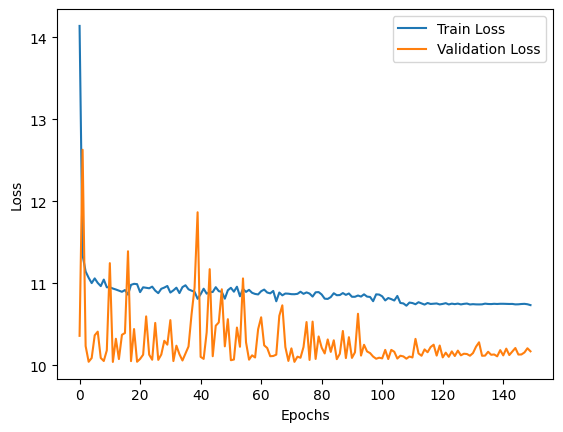

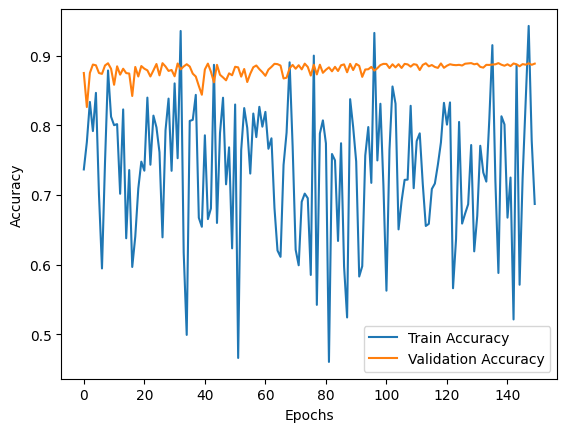

25/25 [==============================] - 0s 2ms/step - loss: 9.9622 - eval_accuracy: 0.6694
Test Loss: 9.962
Test Accuracy: 0.669


c:\Users\k10dh\anaconda3\envs\TeamProject\lib\site-packages\keras\engine\training.py:2448: UserWarning: Metric EvalAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


In [16]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련 및 검증 평가 지표 추출
train_accuracy = history.history['eval_accuracy']
val_accuracy = history.history['val_eval_accuracy']

# 평가 지표 그래프 그리기
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 테스트 세트 평가
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", round(loss, 3))
print("Test Accuracy:", round(accuracy, 3))
